## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [7]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.40MB/s]


Text(0.5, 1.0, 'Image label: 2')

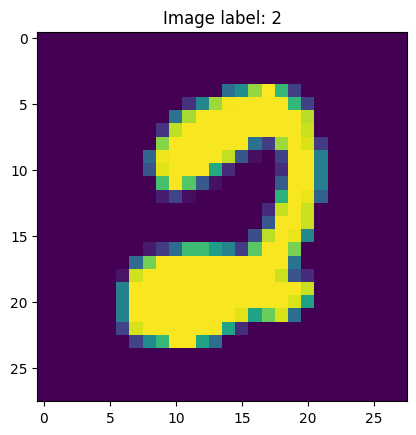

In [8]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [26]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 588)
        self.bn1 = nn.BatchNorm1d(588)
        self.fc2 = nn.Linear(588, 392)
        self.bn2 = nn.BatchNorm1d(392)
        self.fc3 = nn.Linear(392, 196)
        self.dropout = nn.Dropout(0.5)
        self.fc4 = nn.Linear(196, num_classes)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.elu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.elu(x)

        x = self.fc3(x)
        x = self.elu(x)

        x = self.dropout(x)
        x = self.fc4(x)
        return x


# Creating model instance
model = Model() # your code here


Ниже доступны локальные тесты для проверки вашей модели:

In [27]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

loaders = {"train": train_data_loader, "valid": test_data_loader}

In [37]:
def train(model, criterion, optimizer):
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in tqdm(dataloader):
              if k == "train":
                  model.train()  # <------------------ переводим модель в режим train
                  optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                  outp = model(x_batch.reshape(-1, 784))
                  loss = criterion(outp, nn.functional.one_hot(y_batch , num_classes=10).float()) # <-считаем "лосс" для логистической регрессии
                  loss.backward()  # <--------------- считаем градиенты
                  optimizer.step()  # <-------------- делаем шаг градиентного спуска
              else:
                  model.eval()  # <------------------ переводим модель в режим eval
                  with torch.no_grad():  # <--------- НЕ считаем градиенты
                      outp = model(x_batch.reshape(-1, 784))  # <------------- получаем "логиты" из модели
              preds = outp.argmax(-1)
              correct =  torch.mean((preds==y_batch).float())
              all = y_batch.shape[0]
              epoch_correct += torch.sum((preds==y_batch).float())
              epoch_all += all
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return model, accuracy['valid']


In [38]:
model, elu_accuracy = train(model, criterion, optimizer)

100%|██████████| 1875/1875 [00:37<00:00, 50.20it/s]


Epoch: 1
Loader: train. Accuracy: 0.9134833216667175


100%|██████████| 313/313 [00:02<00:00, 125.80it/s]


Loader: valid. Accuracy: 0.9581999778747559


100%|██████████| 1875/1875 [00:38<00:00, 49.27it/s]


Epoch: 2
Loader: train. Accuracy: 0.9440333247184753


100%|██████████| 313/313 [00:02<00:00, 122.31it/s]


Loader: valid. Accuracy: 0.9632999897003174


100%|██████████| 1875/1875 [00:39<00:00, 47.28it/s]


Epoch: 3
Loader: train. Accuracy: 0.9546666741371155


100%|██████████| 313/313 [00:04<00:00, 67.38it/s] 


Loader: valid. Accuracy: 0.9643999934196472


100%|██████████| 1875/1875 [00:38<00:00, 48.85it/s]


Epoch: 4
Loader: train. Accuracy: 0.9614666700363159


100%|██████████| 313/313 [00:02<00:00, 107.25it/s]


Loader: valid. Accuracy: 0.9731000065803528


100%|██████████| 1875/1875 [00:38<00:00, 48.40it/s]


Epoch: 5
Loader: train. Accuracy: 0.9653000235557556


100%|██████████| 313/313 [00:02<00:00, 120.79it/s]


Loader: valid. Accuracy: 0.9758999943733215


100%|██████████| 1875/1875 [00:38<00:00, 48.60it/s]


Epoch: 6
Loader: train. Accuracy: 0.9686166644096375


100%|██████████| 313/313 [00:02<00:00, 108.11it/s]


Loader: valid. Accuracy: 0.9747999906539917


100%|██████████| 1875/1875 [00:40<00:00, 46.18it/s]


Epoch: 7
Loader: train. Accuracy: 0.9707666635513306


100%|██████████| 313/313 [00:02<00:00, 112.78it/s]


Loader: valid. Accuracy: 0.9767000079154968


100%|██████████| 1875/1875 [00:45<00:00, 40.87it/s]


Epoch: 8
Loader: train. Accuracy: 0.973633348941803


100%|██████████| 313/313 [00:03<00:00, 92.27it/s] 


Loader: valid. Accuracy: 0.9790999889373779


100%|██████████| 1875/1875 [00:40<00:00, 46.62it/s]


Epoch: 9
Loader: train. Accuracy: 0.9743333458900452


100%|██████████| 313/313 [00:02<00:00, 110.19it/s]


Loader: valid. Accuracy: 0.9769999980926514


100%|██████████| 1875/1875 [00:39<00:00, 47.43it/s]


Epoch: 10
Loader: train. Accuracy: 0.977483332157135


100%|██████████| 313/313 [00:03<00:00, 96.08it/s] 

Loader: valid. Accuracy: 0.973800003528595


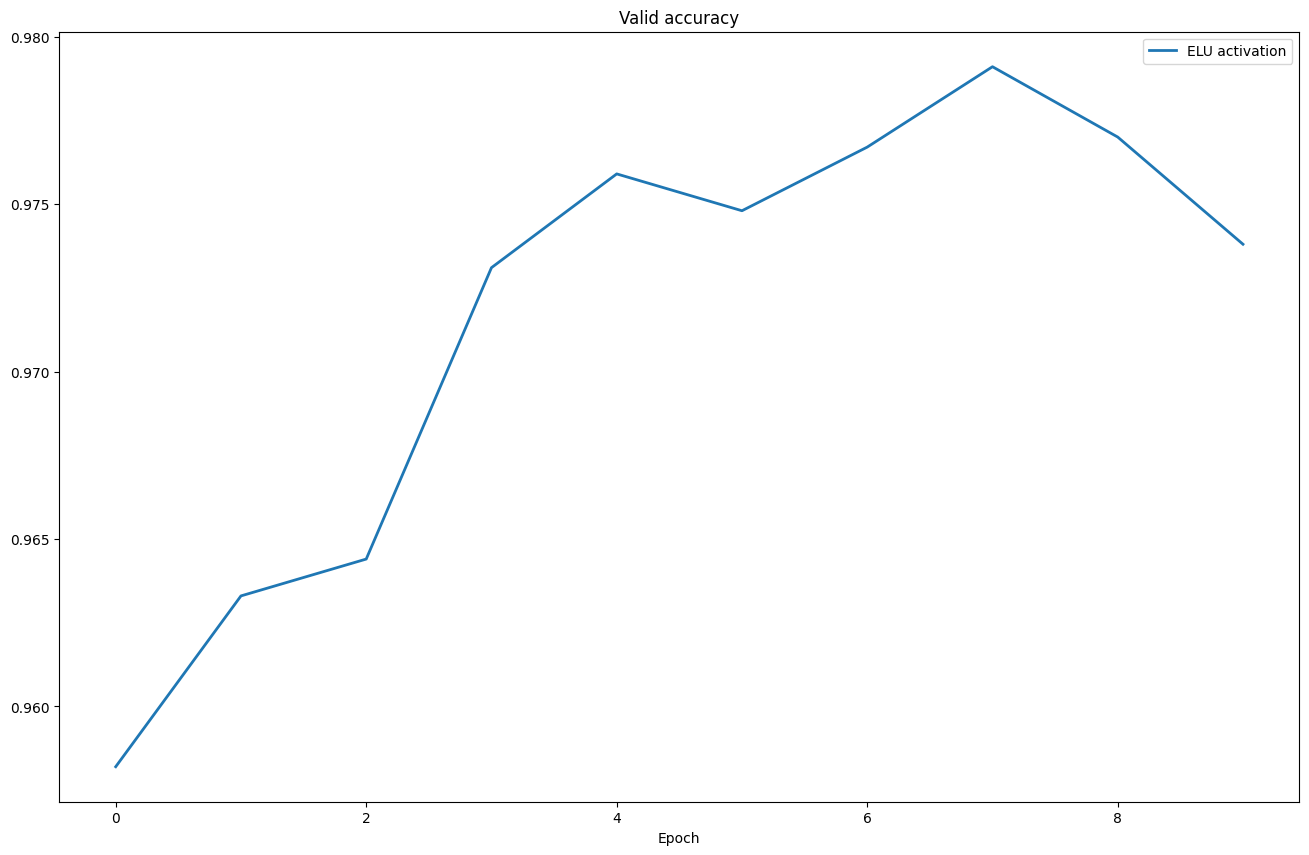

In [41]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(10), lenet_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [42]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [43]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.98685


In [44]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [45]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9738


Проверка, что пороги пройдены:

In [46]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [47]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!